# Summary 1

![](https://www.kth.se/polopoly_fs/1.1032323.1606724850!/image/Segelfartygens%20chans%20att%20ta%20revansch%2003_liten.jpg)

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
#%config Completer.use_jedi = False

In [52]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
import numpy as np
import yaml

from vessel_manoeuvring_models.visualization.plot import track_plot, plot
from phd.visualization.plot_ship import track_plots
from vessel_manoeuvring_models.extended_kalman_vmm import ExtendedKalman, SystemMatrixes
import sys
sys.path.append("../")
from vmm_abkowitz_diminished import vmm as vmm
from wPCC_pipeline.pipelines.brix.nodes import initial_parameters, extract_added_masses
from wPCC_pipeline.pipelines.preprocess.nodes import load, add_thrust
from wPCC_pipeline.pipelines.filter_data_extended_kalman.nodes import guess_covariance_matrixes, initial_state, extended_kalman_filter, extended_kalman_smoother
from wPCC_pipeline.pipelines.motion_regression.nodes import predict_force, fit_motions, create_model_from_motion_regression
from wPCC_pipeline.pipelines.prediction.nodes import simulate_euler
from phd.pipelines.load_7m.nodes import fix_interpolated_angle
from sklearn.metrics import mean_squared_error
from vessel_manoeuvring_models.models.vmm import VMM, Simulator, ModelSimulator, get_coefficients
import sympy as sp
from functools import reduce
from operator import add
from vessel_manoeuvring_models.symbols import *
import vessel_manoeuvring_models.symbols as symbols
from IPython.display import display
from vessel_manoeuvring_models.prime_system import df_prime
from vessel_manoeuvring_models.substitute_dynamic_symbols import run, lambdify
from vessel_manoeuvring_models.models.vmm import VMM, Simulator, ModelSimulator
from vessel_manoeuvring_models.parameters import df_parameters
from phd.helpers import mean
from vessel_manoeuvring_models.angles import mean_angle
from vessel_manoeuvring_models.angles import smallest_signed_angle
import inspect
from phd.visualization.maps import plot_map, plot_trips, plot_missions, plot_tests

import matplotlib.pyplot as plt
plt.style.use('bmh')

In [3]:
import anyconfig
globals_path = "../../conf/base/globals.yml"
global_variables = anyconfig.load(globals_path)
ships = global_variables["ships"]

In [47]:
%reload_kedro
ship='7m'
time_series = catalog.load(f"{ship}.tests")
ship_data = catalog.load(f"{ship}.ship_data")
time_series_meta_data = catalog.load(f"{ ship }.test_meta_data")
time_series_meta_data['date'] = pd.to_datetime(time_series_meta_data['date'])
time_series_meta_data.sort_values(by='date', inplace=True)
results_no_wind = catalog.load(f"{ ship }.simulation_no_wind")
results_wind = catalog.load(f"{ ship }.simulation_wind")
model_loaders = catalog.load(f"{ship}.models")
simulation_MDL_vmm_abkowitz_diminished = catalog.load(f"wPCC.simulation_MDL_vmm_abkowitz_diminished")
time_series_MDL = catalog.load(f"wPCC.time_series_preprocessed.ek_smooth")
ship_data_MDL = catalog.load(f"wPCC.ship_data")
units = catalog.load(f"{ship}.units")

[05/24/23 09:59:09] INFO     Resolved project path as: /home/maa/dev/PHD.                           ]8;id=843635;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=911833;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#134\134]8;;\
                             To set a different path, run '%reload_kedro <project_root>'                           

[05/24/23 09:59:09] INFO     Kedro project phd                                                      ]8;id=355828;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=889175;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#103\103]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=977941;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=849151;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#104\104]8;;\
                             'pipelines'                                                                           

                    INFO     Registered line magic 'run_viz'                                        ]8;id=342567;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=912517;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#110\110]8;;\

                    INFO     Loading data from '7m.tests' (PartitionedDataSet)...               ]8;id=52573;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=38326;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from '7m.ship_data' (YAMLDataSet)...                  ]8;id=416314;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=340327;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from '7m.test_meta_data' (CSVDataSet)...              ]8;id=165397;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=123118;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from '7m.simulation_no_wind' (PartitionedDataSet)...  ]8;id=172257;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=32651;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from '7m.simulation_wind' (PartitionedDataSet)...     ]8;id=844596;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=366325;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from '7m.models' (PartitionedDataSet)...              ]8;id=923698;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=364586;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'wPCC.simulation_MDL_vmm_abkowitz_diminished'    ]8;id=466347;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=740807;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             (PartitionedDataSet)...                                                               

                    INFO     Loading data from 'wPCC.time_series_preprocessed.ek_smooth'        ]8;id=463381;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=633516;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             (PartitionedDataSet)...                                                               

                    INFO     Loading data from 'wPCC.ship_data' (YAMLDataSet)...                ]8;id=862248;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=865018;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from '7m.units' (YAMLDataSet)...                      ]8;id=407098;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=203776;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

## SSPA MDL
System identification in a laboratory environment.

In [57]:
simulation_MDL_vmm_abkowitz_diminished

{'wpcc.updated.22611.ek_smooth': <bound method AbstractVersionedDataSet.load of <kedro.extras.datasets.pandas.csv_dataset.CSVDataSet object at 0x7efd51f502b0>>,
 'wpcc.updated.22612.ek_smooth': <bound method AbstractVersionedDataSet.load of <kedro.extras.datasets.pandas.csv_dataset.CSVDataSet object at 0x7efd51f51ed0>>,
 'wpcc.updated.22613.ek_smooth': <bound method AbstractVersionedDataSet.load of <kedro.extras.datasets.pandas.csv_dataset.CSVDataSet object at 0x7efd51f53850>>,
 'wpcc.updated.22614.ek_smooth': <bound method AbstractVersionedDataSet.load of <kedro.extras.datasets.pandas.csv_dataset.CSVDataSet object at 0x7efd51f50f40>>,
 'wpcc.updated.22615.ek_smooth': <bound method AbstractVersionedDataSet.load of <kedro.extras.datasets.pandas.csv_dataset.CSVDataSet object at 0x7efd51f53010>>,
 'wpcc.updated.22616.ek_smooth': <bound method AbstractVersionedDataSet.load of <kedro.extras.datasets.pandas.csv_dataset.CSVDataSet object at 0x7efd51f52260>>,
 'wpcc.updated.22635.ek_smooth': <

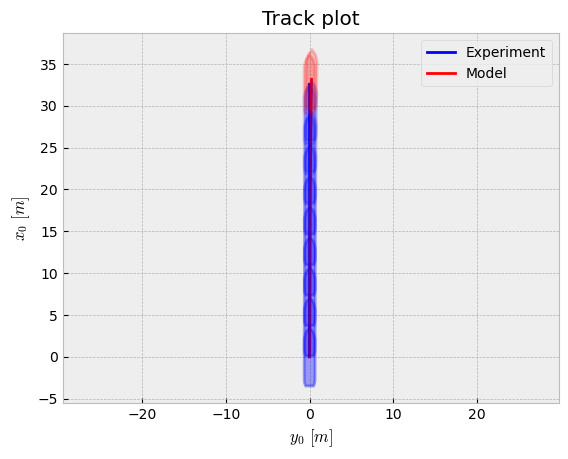

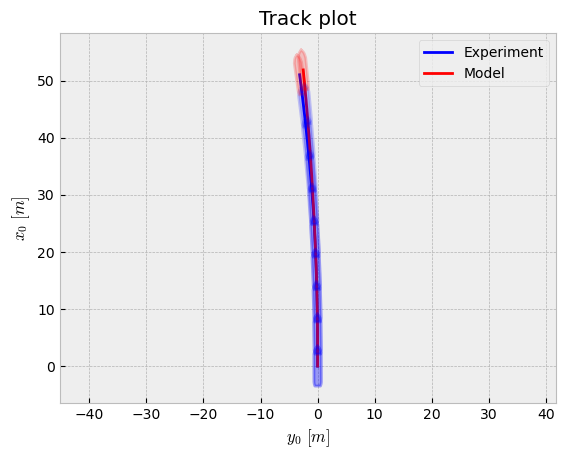

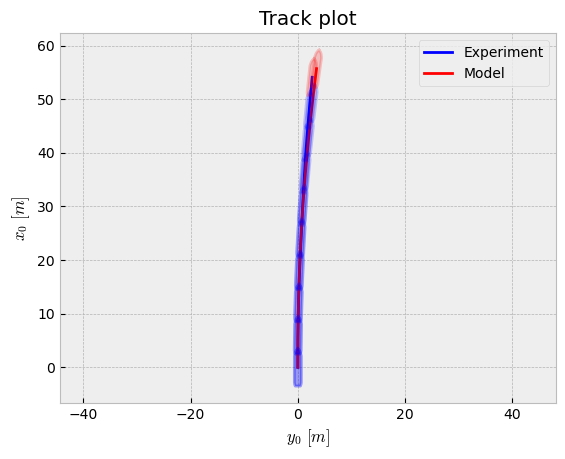

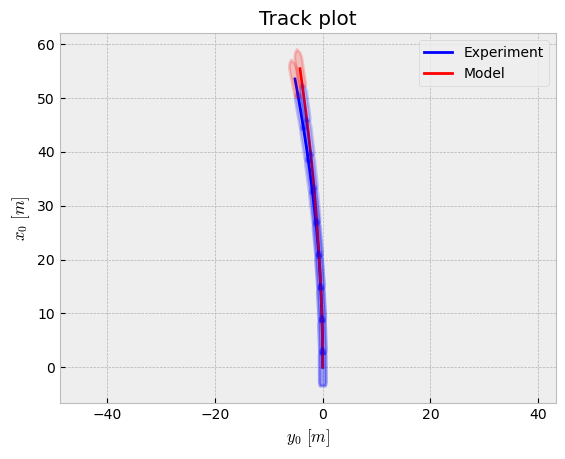

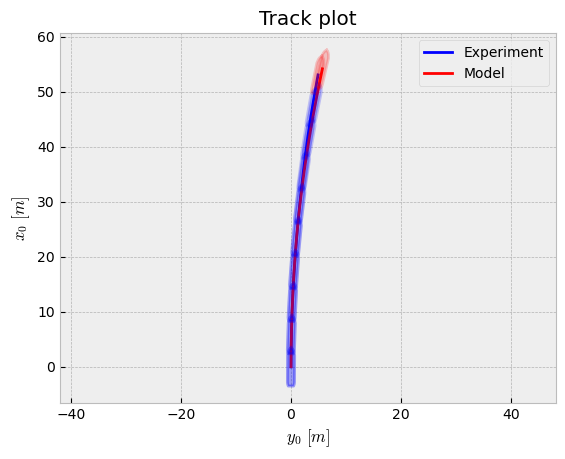

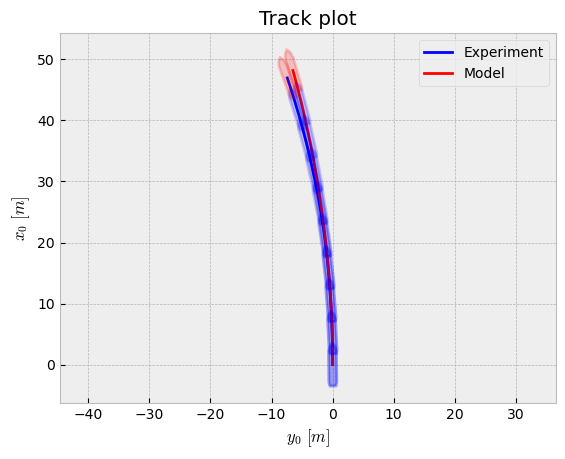

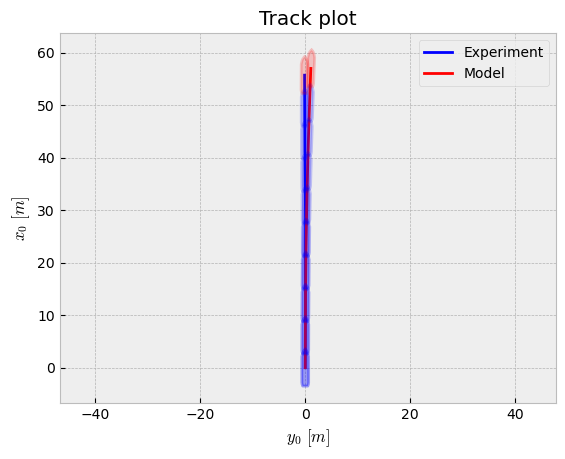

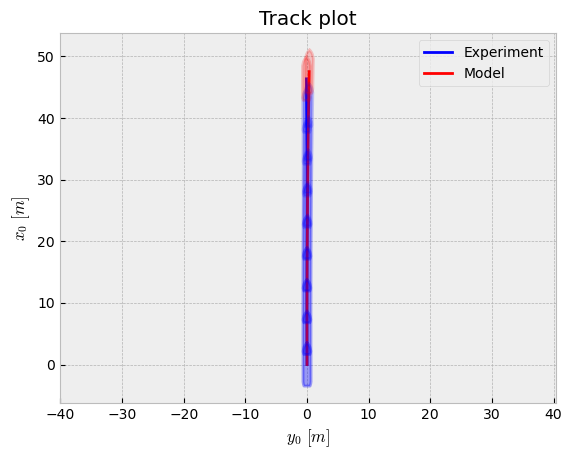

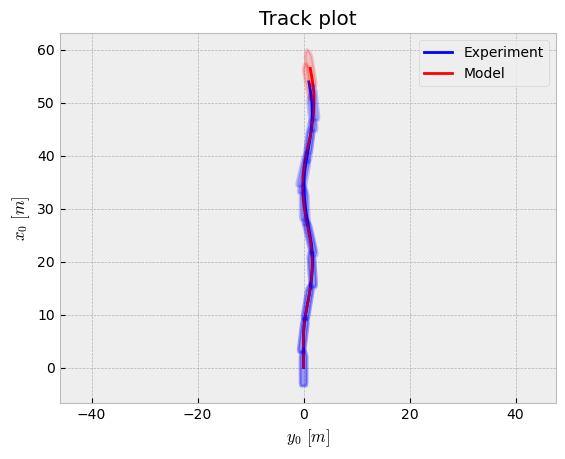

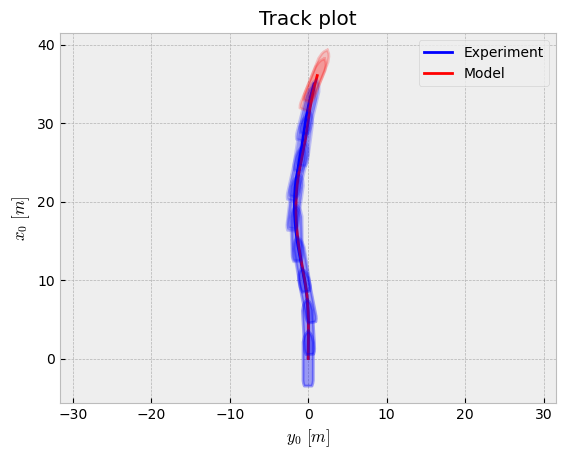

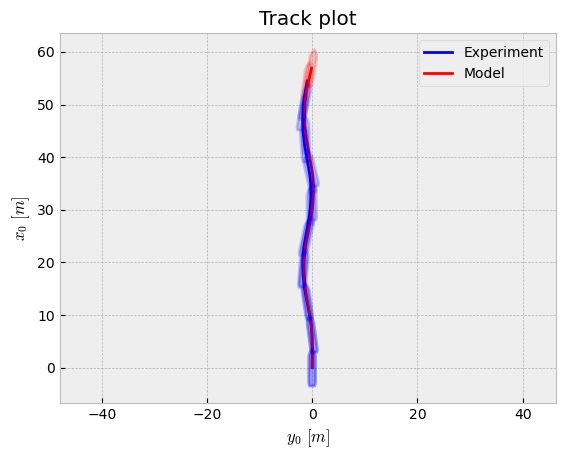

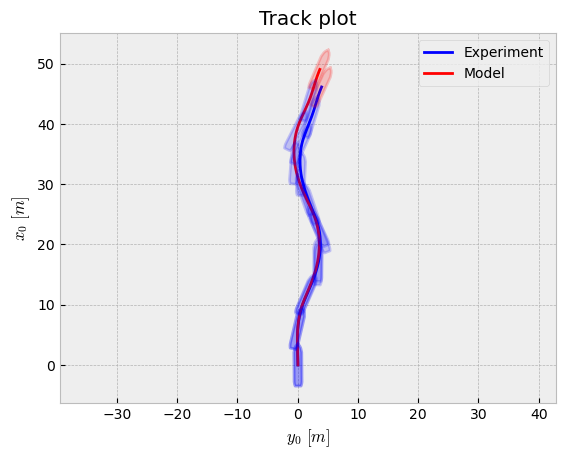

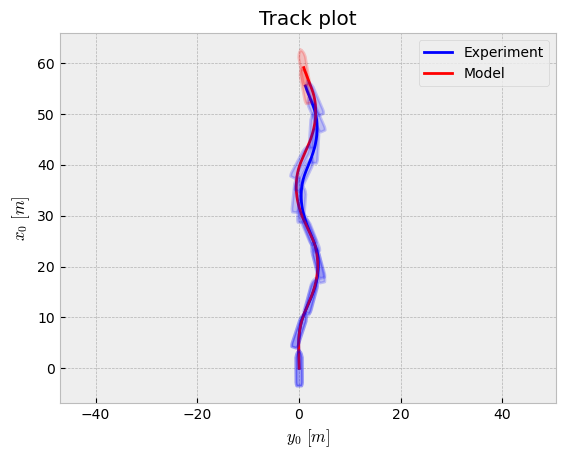

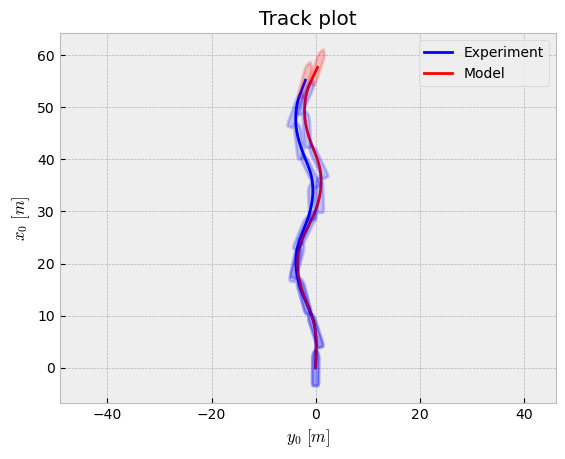

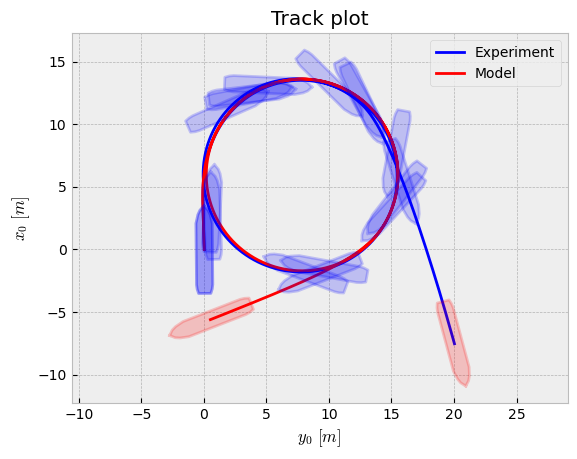

In [5]:
for key, loader in simulation_MDL_vmm_abkowitz_diminished.items():
    
    sim_result = loader()
    data2 = time_series_MDL[key]()
    
    dataframes = {
    'Experiment':data2,
    'Model': sim_result,
    }
    time_window=[0, np.inf]
    ax = track_plots(dataframes=dataframes, lpp=ship_data['L'], beam=ship_data['B'], 
                 time_window=time_window, N=10);

## Lake tests
System identification in a real environment with tests in a sheltered area with a scale model of the ship that is a little bit larger than the ship model that was used in the laboratory as seen in the table below. 

In [42]:
ship_datas = pd.concat((
pd.Series(ship_data_MDL,name='Laboratory'),
pd.Series(ship_data,name='Lake'),
),axis=1).transpose()
ship_datas

T         L        CB         B     rho       x_G            m          I_z    volume  scale_factor       x_r  TWIN       x_p         D   w_p0  A_XV   A_YV  rho_A
Laboratory  0.206311  5.014563  0.450342  0.946602  1000.0  0.000000   441.026784   693.124397  0.441027          41.2 -2.422199   1.0 -2.422199  0.121359  0.151   NaN    NaN    NaN
Lake        0.284000  7.000000  0.411528  1.300000  1025.0 -0.326667  1155.000000  3386.031484  1.063552          30.0 -3.316846   1.0       NaN  0.170000    NaN  1.12  6.037  1.225

In [6]:
time_series_meta_data.head()

yaw       cog       sog  rudderTarget  rudderAngle   latitude  longitude  heelAngle    awaBow    awsBow    twaBow    twsBow  awaStern  awsStern  twaStern  twsStern  thrusterTarget  courseTarget  pitchAngle     GyroX     GyroY     GyroZ    AccelX    AccelY    AccelZ  awaBowRAW  awsBowRAW  twaBowRAW  twsBowRAW  awaSternRAW  awsSternRAW  twsSternRAW     delta         V         U      beta         u         v       psi       phi         r       u1d       v1d       r1d       y_GPS        x_GPS           x0          y0       aws       awa       tws       twa  zigzag_test_id  inbetween_zigzags_id                       date                                           missions       type           time_series
id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
15  0.175628  0.166878  1.637572      2.599364     2.408736  59.288041  18.321386   0.015447  0.231330  2.488504  1.487030  1.694987  0.250999  2.423934  1.522064  1.637990       63.379467      0.229169    0.006974  0.001312 -0.000608  0.002449  0.078864 -0.149783 -9.817212   0.227797   2.489710   1.497060   1.693252     0.249425     2.424102     1.636439 -0.041247  1.637572  1.637572  0.008285  1.622737 -0.012201  0.175628  0.015447  0.001859  0.001220 -0.000032  0.000016  177.355077   979.733387   981.540847  177.351765  2.456906  0.236351  1.645354  1.540517             NaN                  15.0 2021-04-28 09:59:07.245075  Mission started at: 2021/4/29,9:22:58,command ...  inbetween  motoring_7m_all_data
0  -2.864242 -2.917641  2.234649      2.868355     2.832776  59.290854  18.324044   0.011661 -0.058411  1.826679 -3.087927  0.716626 -0.118637  1.810751 -3.054401  0.748773      100.000000     -3.127585    0.009372  0.001654 -0.000898  0.017665  0.109068 -0.097567 -9.823668  -0.058420   1.811687  -2.989640   0.715064    -0.119148     1.805596     0.741702 -0.049476  2.234649  2.234649  0.057212  2.200031 -0.120536 -2.864242  0.011661  0.017060 -0.000953 -0.002834  0.000107  330.864004  1292.087658  1289.648970  330.619592  1.808642 -0.086549  0.668062  0.193023             0.0                   NaN 2021-04-28 10:27:01.224843  ZigZag: start (59.29170990,18.32409477),ZigZag...     zigzag  motoring_7m_all_data
16 -3.066111 -3.014636  1.549029     -1.737815    -0.380608  59.288431  18.323445   0.025616 -0.338841  3.581301 -0.957529  2.693383 -0.158267  3.315870 -0.747517  2.338011       75.456209     -3.133967    0.009551  0.001808 -0.001829 -0.041992  0.122821 -0.277251 -9.812322  -0.336998   3.595232  -0.859189   2.704765    -0.177163     3.328282     2.347661  0.006174  1.549029  1.549029 -0.281185  1.440949  0.324024 -3.066111  0.025616 -0.042787  0.000148  0.000675 -0.000102  295.051010  1022.471283  1020.830261  295.218944  3.461757 -0.255802  2.495119  2.002743             NaN                  16.0 2021-04-28 10:28:31.023738  CMD 17  stopped. comment: ,CMD 18 started. run...  inbetween  motoring_7m_all_data
1   2.976625  3.001172  2.168764      1.477648     1.630257  59.282847  18.322966   0.022045 -0.282939  6.409136 -0.453019  4.581796 -0.283185  5.890818 -0.491481  4.070700      100.000000     -3.141585    0.008296  0.001285 -0.001100 -0.008247  0.114604 -0.222498 -9.828266  -0.258706   6.441708  -0.427223   4.606597    -0.256902     5.943986     4.109235 -0.028388  2.168764  2.168764 -0.024792  2.135522  0.055709  2.976

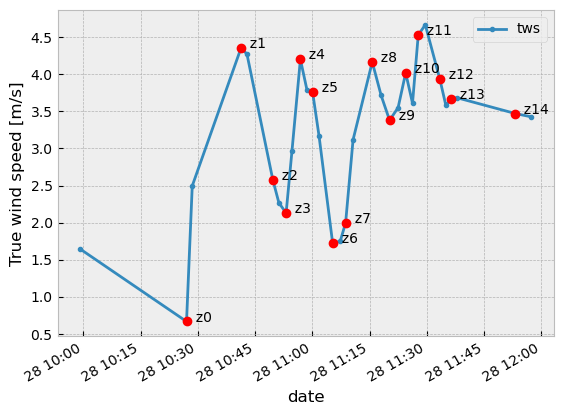

In [25]:
fig,ax=plt.subplots()
time_series_meta_data.plot(x='date', y='tws', style='.-', ax=ax)

for id, row in time_series_meta_data.groupby(by='type').get_group('zigzag').iterrows():
    ax.plot(row['date'], row['tws'],'ro')
    ax.text(x=row['date'], y=row['tws'], s=f"  z{id}")

ax.set_ylabel('True wind speed [m/s]');

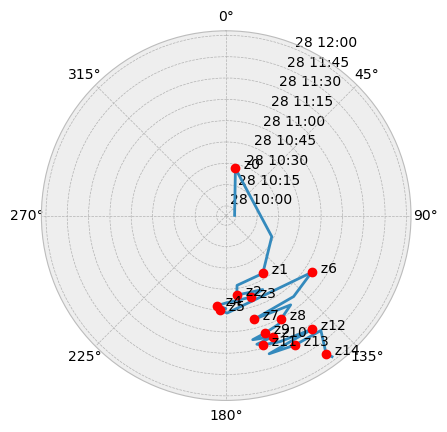

In [24]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

ax.plot(time_series_meta_data['twa'], time_series_meta_data.date)
ax.set_theta_direction(-1)
ax.set_theta_zero_location("N")

for id, row in time_series_meta_data.groupby(by='type').get_group('zigzag').iterrows():
    ax.plot(row['twa'], row['date'],'ro')
    ax.text(row['twa'], row['date'], s=f"  z{id}")

In [9]:
_ = []
for id, loader in time_series.items():
    df_ = loader()
    df_['id'] = str(id)
    _.append(df_)
    
data_all = pd.concat(_)
data_all.set_index("global time", inplace=True)
assert data_all.index.is_unique
data_all.sort_index(inplace=True)
data_all['trip_no'] = data_all['id'].astype(int)

In [10]:
data_all.head()

yaw     cog     sog  rudderTarget  rudderAngle   latitude  longitude  heelAngle  awaBow  awsBow  twaBow  twsBow  awaStern  awsStern  twaStern  twsStern  thrusterTarget  courseTarget  pitchAngle   GyroX   GyroY   GyroZ  AccelX  AccelY  AccelZ  awaBowRAW  awsBowRAW  twaBowRAW  twsBowRAW  awaSternRAW  awsSternRAW  twsSternRAW                                            mission                        date     delta       V       U    beta         u         v       psi     phi         r       u1d       v1d       r1d     y_GPS     x_GPS        x0        y0      aws      awa       tws       twa  id  trip_no
global time                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
0.000000     6.2749  0.0566  0.5219        0.3838       0.2322  59.279236  18.318385     0.0087  3.0003  1.4838  2.9773  1.9999    2.7980    1.6423    2.8205    2.1337            20.0           0.0      0.0052  0.0165  0.0109 -0.0006  0.0412 -0.1080 -9.8133     2.9574     1.7029     2.8695     2.2150       2.7732       1.7491       2.2361  Mission started at: 2021/4/29,9:22:58,command ...  2021-04-28 09:59:07.245075 -0.004053  0.5219  0.5219  6.2183  0.520802  0.033840 -0.008285  0.0087  0.002500  0.039800  0.045382 -0.002503  0.000000  0.000000  2.755804 -0.517850  1.72600  2.86530  2.224683  2.935590  15       15
0.199987     6.2754  0.0732  0.5305        0.5050       0.4644  59.279237  18.318385     0.0139  2.9985  1.5056  2.9758  2.0216    2.7949    1.6504    2.8181    2.1413            20.0           0.0      0.0071  0.0344  0.0056  0.0009  0.0789 -0.1363 -9.9561     2.9707     1.7646     2.8932     2.2781       2.7576       1.7491       2.2329                                                NaN  2021-04-28 09:59:07.445062 -0.008105  0.5305  0.5305  6.2022  0.528761  0.042916 -0.007785  0.0139  0.002000  0.016121  0.039099 -0.022498 -0.000706  0.099428  2.855491 -0.517178  1.75685  2.86415  2.261307  2.938756  15       15
0.400023     6.2758  0.0877  0.5344        0.4864       0.4644  59.279238  18.318385     0.0203  3.0003  1.5283  2.9764  2.0448    2.7920    1.6580    2.8152    2.1486            20.0           0.0      0.0074  0.0319 -0.0025 -0.0001  0.0691 -0.1952 -9.9039     3.0213     1.8006     2.9712     2.3241       2.7576       1.7491       2.2369                                                NaN  2021-04-28 09:59:07.645098 -0.008105  0.5344  0.5344  6.1881  0.531986  0.050737 -0.007385  0.0203 -0.002501  0.016177  0.009379 -0.002488  0.000710  0.187044  2.943313 -0.514660  1.77485  2.88945  2.284606  2.961748  15       15
0.599958     6.2753  0.0901  0.5378        0.4684       0.4644  59.279239  18.318385     0.0245  3.0044  1.5488  2.9780  2.0663    2.7894    1.6649    2.8117    2.1553            20.0           0.0      0.0068  0.0107 -0.0033 -0.0012  0.0588 -0.1961 -9.8416     3.0475     1.8006     2.8103     2.3277       2.7576       1.7491       2.2369                                                NaN  2021-04-28 09:59:07.845033 -0.008105  0.5378  0.5378  6.1852  0.535220  0.052612 -0.007885  0.0245 -0.002998 -0.067380 -0.030821  0.017483 -0.000123  0.295859  3.051870 -0.516871  1.77485  2.90255  2.289312  2.972426  15       15
0.800069     6.2747  0.0803  0.5238        0.5080       0.4644  59.279240  18.318385     0.0246  3.0082  1.5622  2.9796  2.0806    2.7851    1.6684    2.8072    2.1584            20.0           0.0      0.0062 -0.0087 -0.0043 -0.0010  0.0571 -0.2200 -9.8506     3.0543     1.743

In [32]:
plot_tests(data_all, meta_data = time_series_meta_data, width=1400, height=800, zoom_start=15)

In [27]:
np.rad2deg(-0.04)

-2.291831180523293

## Wind force influence
The simulation model identified on the MDL tests is used to predict the lake data. The same non dimensional hydrodynamic derivatives, are used for the larger lake model, assuming that the prime system can handle the scaling effect. 
External environmental disturbances in this data - from winds and other sources - are expected to result in poor predictions with the MDL simulation model.
A simulation model with wind forces predicted from wind tunnel tests is also used to predict the data.

In [12]:
model_no_wind = model_loaders['vmm_abkowitz_diminished']()
model_wind = model_loaders['vmm_abkowitz_diminished_wind']()
model_wind.control_keys = ['delta','awa','aws']

In [13]:
subs = [
(u,0),
(v,0),
(r,0),
(delta,0),
(u1d,0),
(v1d,0),
(r1d,0),  
]
lambda_F_Wx = lambdify(model_wind.X_eq.rhs.subs(subs))
lambda_F_Wy = lambdify(model_wind.Y_eq.rhs.subs(subs))
lambda_M_Wz = lambdify(model_wind.N_eq.rhs.subs(subs))

In [54]:
symbols_dict = {key:symbol for key,symbol in symbols.__dict__.items() if isinstance(symbol, sp.Symbol)}

In [55]:
delta0 = -0.045

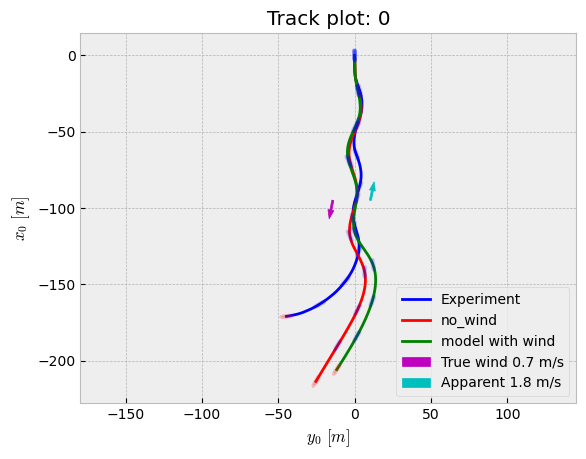

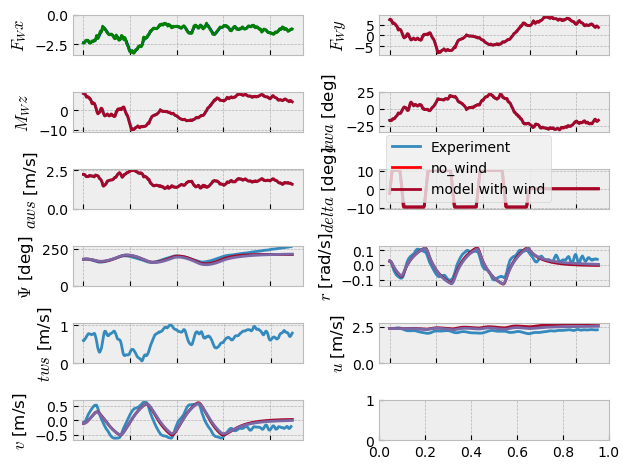

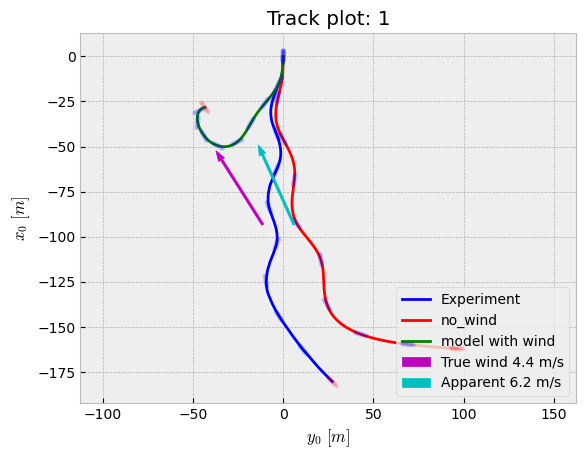

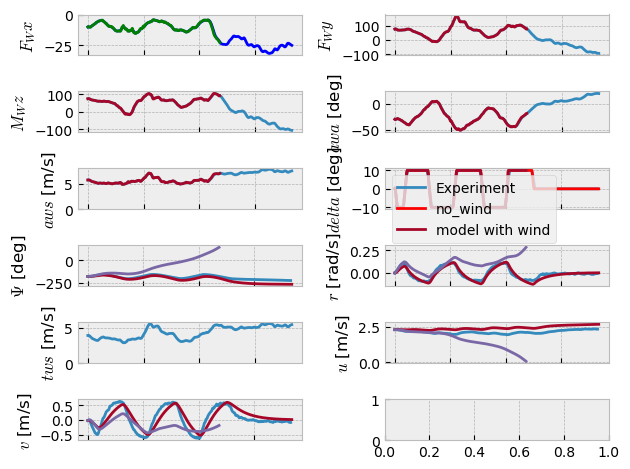

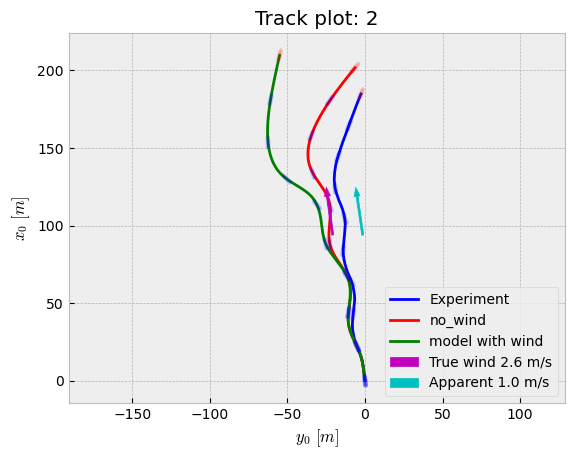

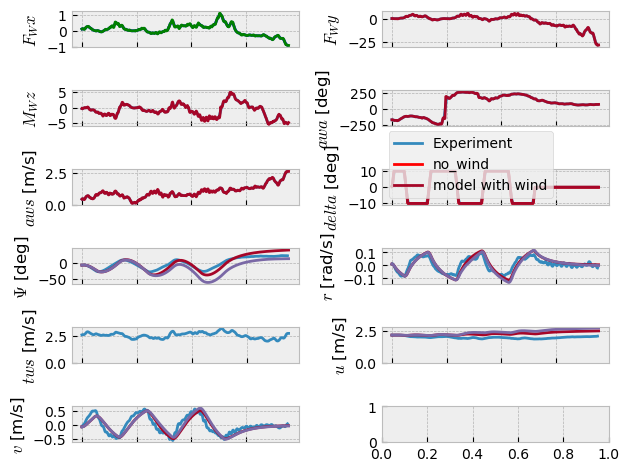

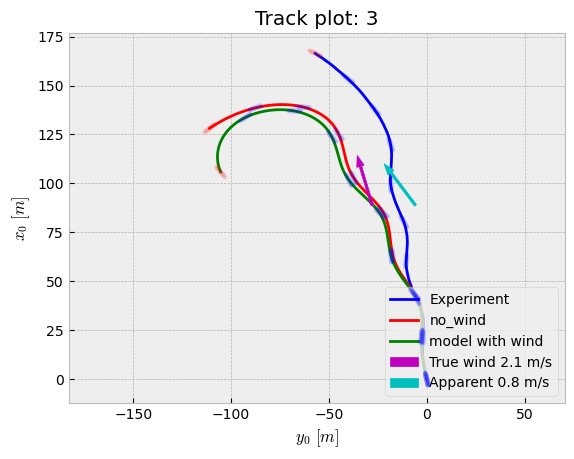

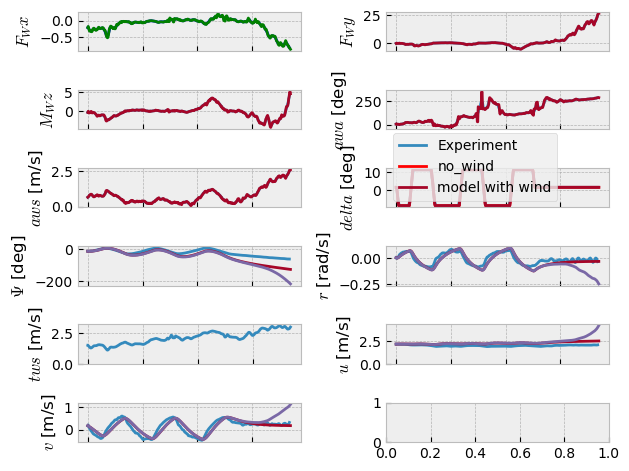

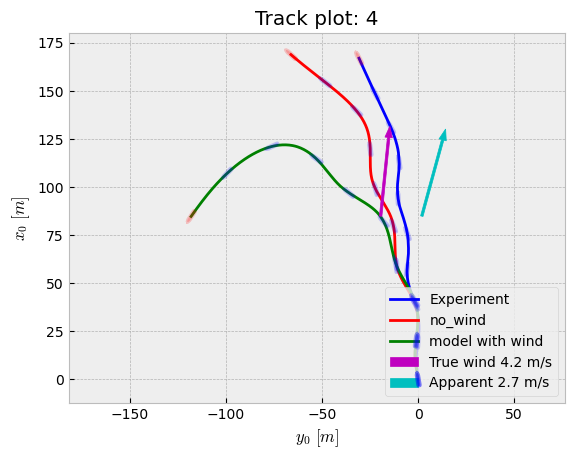

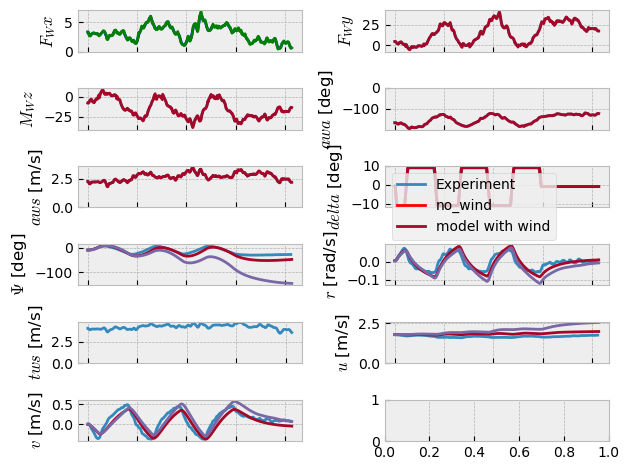

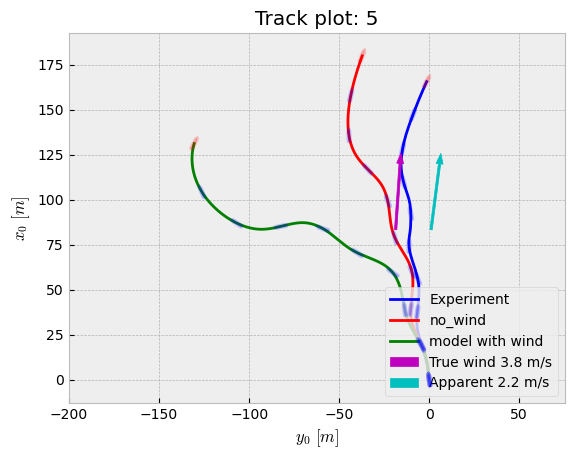

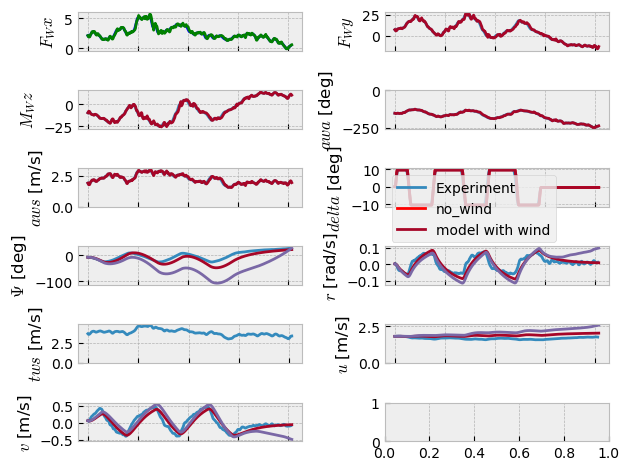

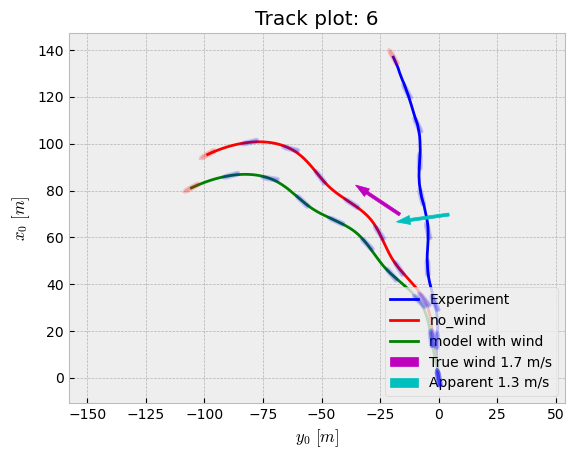

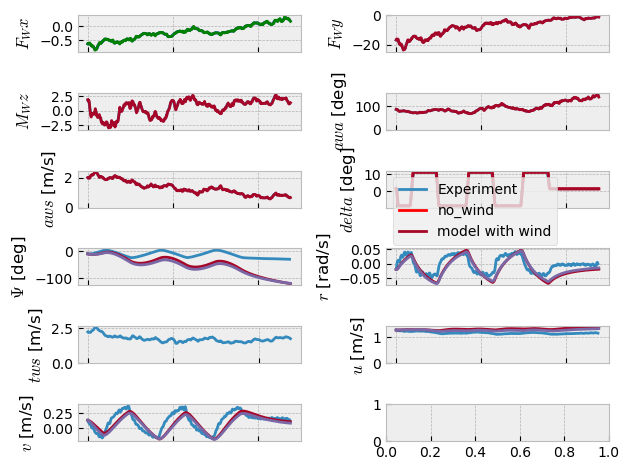

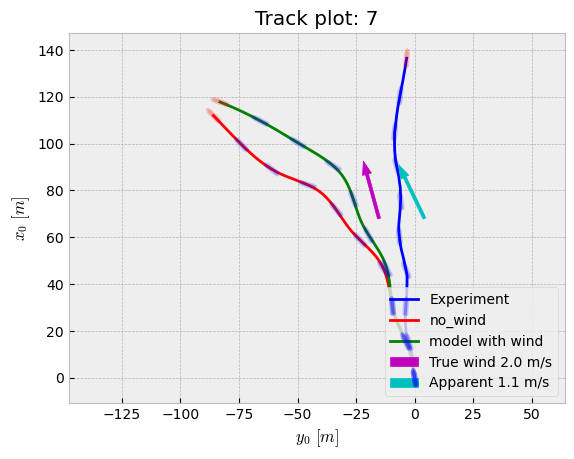

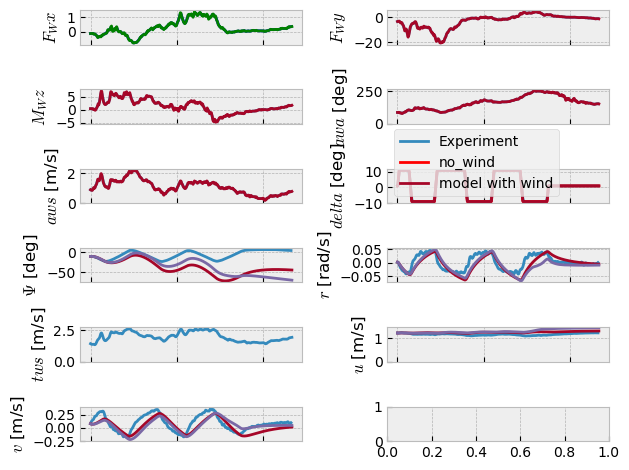

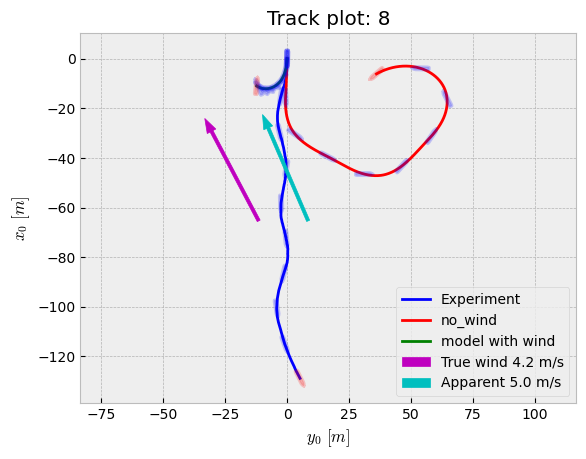

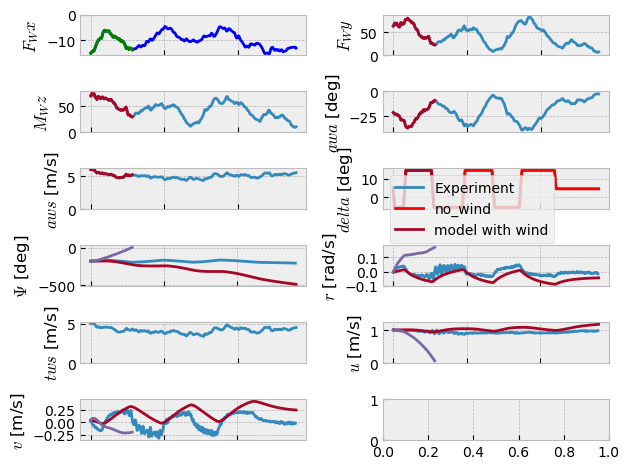

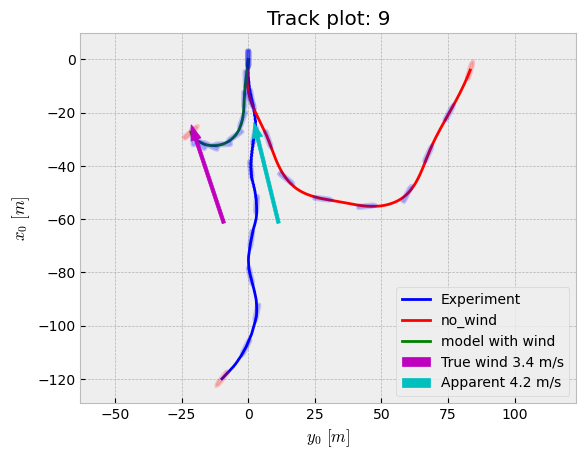

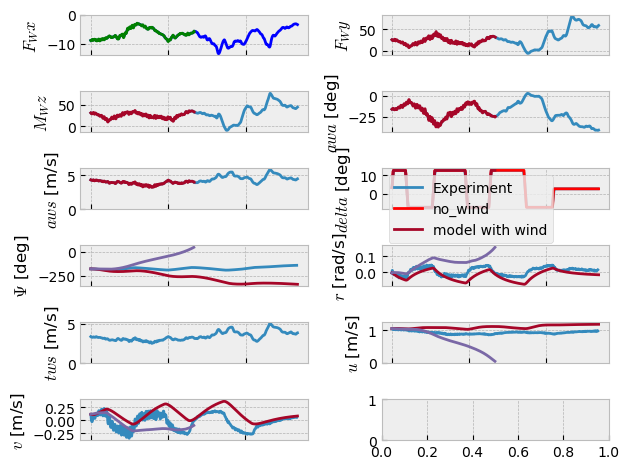

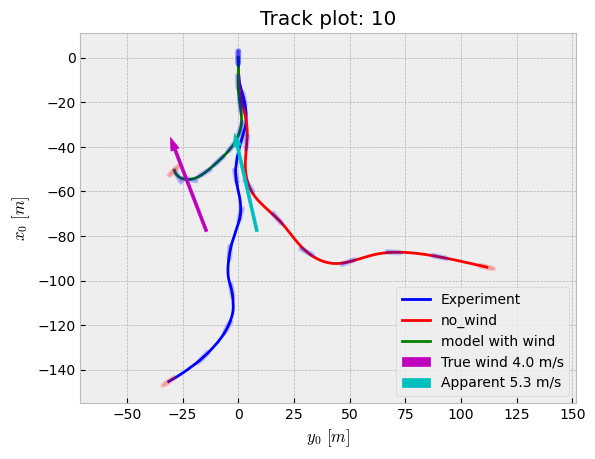

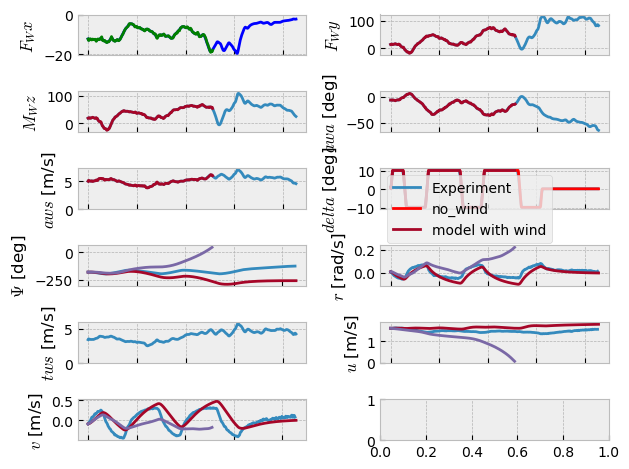

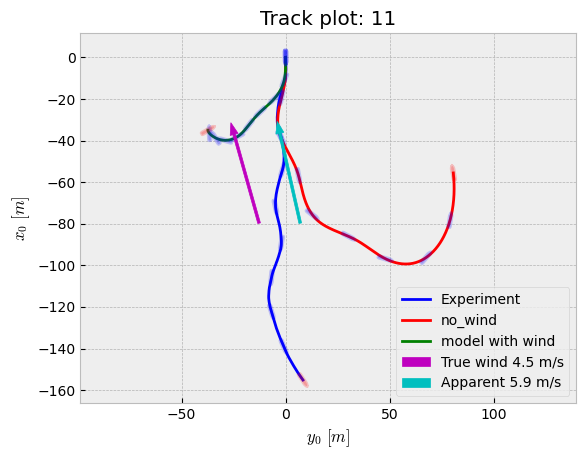

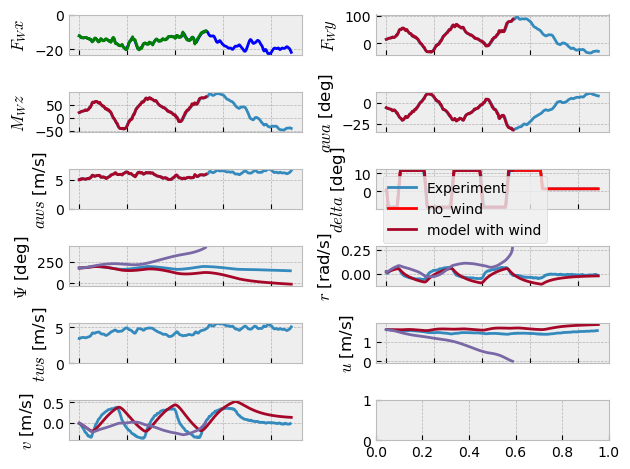

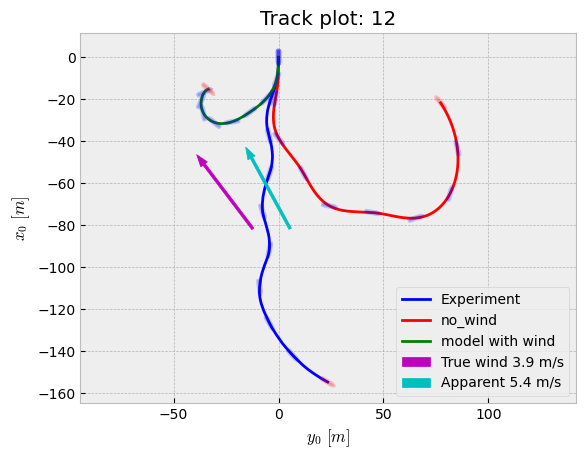

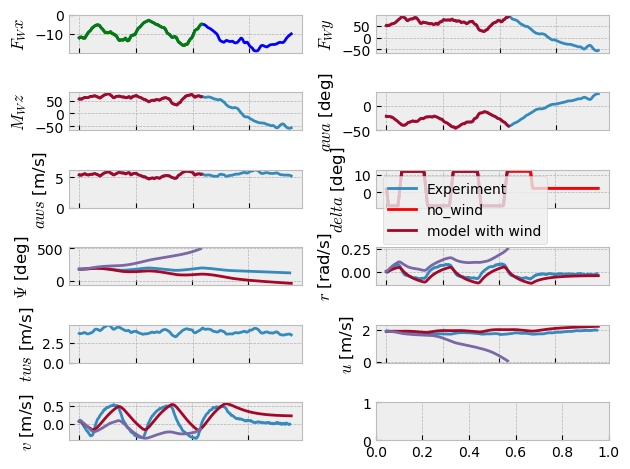

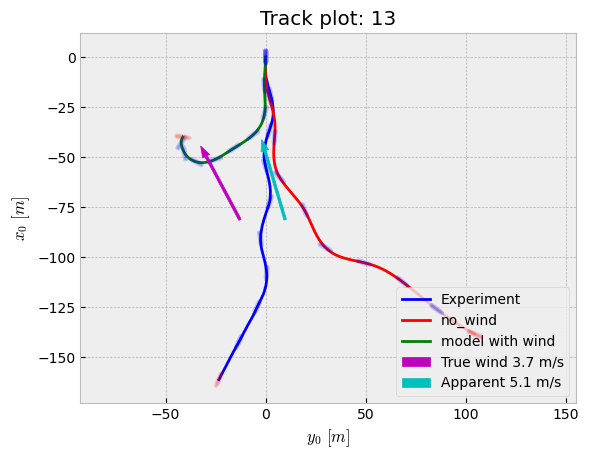

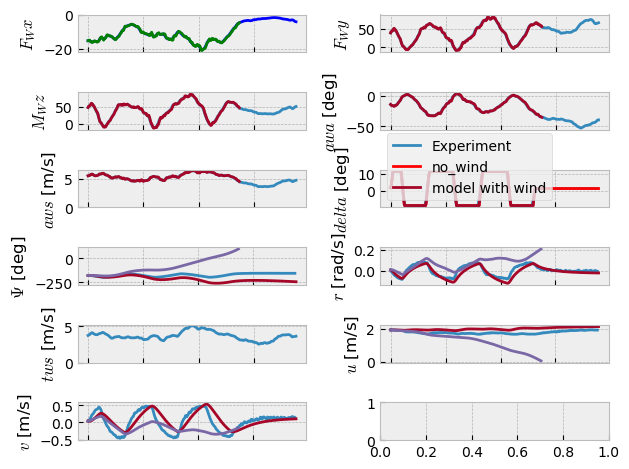

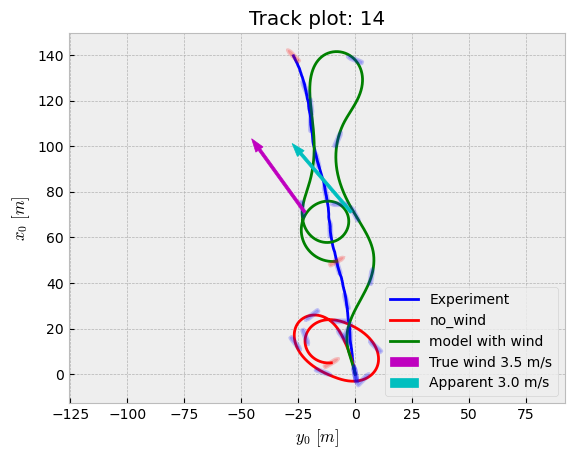

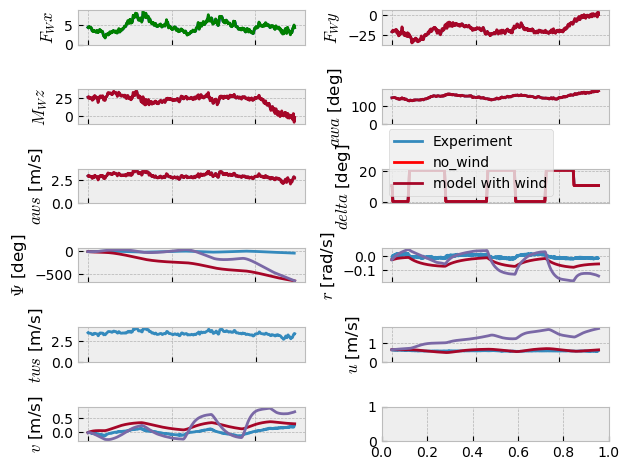

In [56]:
mask = time_series_meta_data['type'] == 'zigzag'
time_series_meta_data_select = time_series_meta_data.loc[mask].sort_values(by='date')

for id, row in time_series_meta_data_select.iterrows():
    
    loader = time_series[str(id)]
    data_raw = loader()
    data = load(raw_data=data_raw)
    data.drop(columns=['mission','date'], inplace=True)
    data['delta']-=delta0  # Neutral rudder angle added
    
    dataframes = {
    'Experiment':data,       
    }
    if str(id) in results_no_wind:
        result_no_wind = results_no_wind[str(id)]()
        dataframes['no_wind'] = result_no_wind
    if str(id) in results_wind:
        result_wind = results_wind[str(id)]()
        result_wind_ = result_wind.copy()
        result_wind_['awa'] = smallest_signed_angle(result_wind_['awa'])
        result_wind['F_Wx'] = run(lambda_F_Wx, inputs=result_wind_, **ship_data, **model_wind.parameters)
        result_wind['F_Wy'] = run(lambda_F_Wy, inputs=result_wind_, **ship_data, **model_wind.parameters)
        result_wind['M_Wz'] = run(lambda_M_Wz, inputs=result_wind_, **ship_data, **model_wind.parameters)
        dataframes['model with wind'] = result_wind
            
    time_window=[0, np.inf]
    ax = track_plots(dataframes=dataframes, lpp=ship_data['L'], beam=ship_data['B'], 
                 time_window=time_window, N=10);
    ax.legend(loc='lower right')
    ax.set_title(f'Track plot: {id}') 
    
    data_ = data.copy()
    data_['awa'] = smallest_signed_angle(data_['awa'])
    data['F_Wx'] = run(lambda_F_Wx, inputs=data_, **ship_data, **model_wind.parameters)
    data['F_Wy'] = run(lambda_F_Wy, inputs=data_, **ship_data, **model_wind.parameters)
    data['M_Wz'] = run(lambda_M_Wz, inputs=data_, **ship_data, **model_wind.parameters)
    
    data_ = data.rolling(6)
    data_ = mean(data_)
    data_['psi'] = np.unwrap(data_['psi'])
    dataframes['Experiment'] =  data_  
    
    plot(dataframes, keys=['u','v','r','delta','psi','aws','awa','tws','F_Wx','F_Wy','M_Wz'], time_window=time_window, units=units, symbols=symbols_dict);

123.65513778590257


Text(0.5, 1.0, 'Track plot: z6')

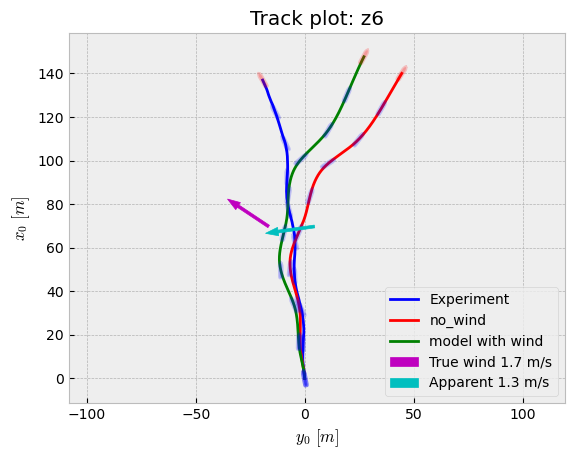

In [21]:
id=6
loader = time_series[str(id)]
data_raw = loader()
data = load(raw_data=data_raw)

dataframes = {
'Experiment':data,       
}

if str(id) in results_no_wind:
    dataframes['no_wind'] = results_no_wind[str(id)]()

if str(id) in results_wind:
    #results_wind['F_Wx'] = run(lambda_F_Wx, inputs=results_wind[id], **ship_data, **model_wind.parameters)
    #results_wind['F_Wy'] = run(lambda_F_Wy, inputs=results_wind[id], **ship_data, **model_wind.parameters)
    #results_wind['M_Wz'] = run(lambda_M_Wz, inputs=results_wind[id], **ship_data, **model_wind.parameters)
    dataframes['model with wind'] = results_wind[str(id)]()
        
time_window=[0, np.inf]
ax = track_plots(dataframes=dataframes, lpp=ship_data['L'], beam=ship_data['B'], 
             time_window=time_window, N=10);
ax.legend(loc='lower right')
ax.set_title(f'Track plot: z{id}') 

## Conclusions
* System identification model "works" in MDL
* ZigZag tests conducted in south to south easterly winds between 0.7 and 4.5 m/s have been studied.
* The ZigZag tests were conducted with non zero neutral rudder angle.
    * A "zero angle" is set just before the zigzag tests (Ulysse).
    * This angle has a constant deviation due to undesired geometric unymmetry in how the ship model was build - small inaccuracies in the  mouting of propellers and rudders etc.
    * The "zero angle" does however also contain a deviation from the weather - mainly wind, but also waves.
    * Finding the split between the constant rudder angle deviation and the weather depending deviation is a challenge. 
* A simulation model with wind forces from wind tunnel tests have been added.
    * This model has problems when going in head wind, this is probably due to the lack of a propeller model.
    * The tranverse wind force $F_{Wy}$ is giving a result that is more similar to the experiment - for most of the tests - compared to the model without wind.
    * The result is however very sensitive to the wind yawing moment $M_{Wz}$, so that the solution with wind is further away from the experiments for some of the tests, compared to the model without wind.
        * The wind coefficient sensitivity should be studied, with perturbed coefficients of Monte Carlo simulations. 

## Further work
* Add a propeller model, and perhaps also another rudder model
    - [x] Propeller model
    - [x] Rudder model
    
- [ ] Improve the Extended Kalman Filter initial state estimate
- [x] Meeting with Ulysse
- [ ] System identification on the real data
- [x] scaling 5 m to 7 m? (Probably ok.)

Three kinds of data:
* Simulated data
* Experimental data (TT/MDL)
* Real data (7m data) (I need a better word here...)